# Amazon Reviews Classifier
Training set: text from 100,000 reviews from Amazon.com, their timestamps, and their star ratings.

Goal: use the textual and temporal data to predict the star ratings using gensim

See README for more details. 

In [1]:
# install libraries
!pip install gensim
!pip install paramiko
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from datetime import *
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [2]:
# read in files
reviews_dict = corpora.Dictionary.load("reviews_dictionary.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
reviews_wc = corpora.MmCorpus('reviews_wordcontext.mm')
reviews_wv = KeyedVectors.load("word_vectors.wv", mmap='r')
reviews_sppmi_300 = np.load('reviews_sppmi_300.npy')
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)


In [3]:
# converts integer object review times to timestamps
converted_times = pd.Series([datetime.fromtimestamp(time) for time in reviews_times[:, 0]])

# densify
Input: a sparse matrix in the format of `reviews_bow` and an integer number of columns

Output: a dense, term-document matrix

In [4]:
def densify(sparse, columns):
    dense_array = np.zeros((len(sparse), columns))
    count = 0
    for arr in sparse :
        for pair in arr :
            idx = pair[0]
            dense_array[count][pair[0]] = pair[1]
        count+=1
    return dense_array

# count_words
Input: a dictionary in the format of `reviews_dict` above, a bag of words corpus in the format of `reviews_bow` above

Output: a list called `counts` that has the total occurrences of each word in the corpus, in the order of the original word indices.

In [5]:
def count_words(gsdict, gsbow):
    count = np.zeros((len(gsdict)), int)
    for arr in gsbow :
        for pair in arr :
            count[pair[0]]+= pair[1]
    return count

In [6]:
# Makes the counts for the 100,000 Amazon reviews.
reviews_counts = count_words(reviews_dict, reviews_bow)

# word_context
Input: 
1. a dictionary in the format of `reviews_dict` above
2. a corpus in the format of `reviews_bow` above
3. a window size (integer)

Output: a **sparse** word-context matrix. The word-context matrix is a square matrix and the number of rows/columns is the number of words in the vocabulary/dictionary. A nonzero term in this matrix represents the number of times word $i$ appears within (and including) the window size distance of word $j$.

In [7]:

def word_context(gsdict, gscorpus, window):
    wc = np.zeros((len(gsdict), len(gsdict)), int)
    # iterate over all elements in dictionary
    for idx, val in gsdict.items():
        # iterate over all document arrays
        for arr in gscorpus :            
            if val in arr :
                indices_to_check = []
                for index, el in enumerate(arr) :
                    if el == val :
                        indices_to_check.append(index)
                for val_idx in indices_to_check :
                    # get max and min index, keep in bounds
                    min_idx = max(0, val_idx - window)
                    max_idx = min(len(arr) - 1, val_idx + window)
                    for i in range(min_idx, max_idx + 1) :
                        if i != val_idx :
                            word = arr[i]
                            word_idx = gsdict.token2id[word]
                            wc[word_idx][idx]+=1
    return sparsify(wc)

def sparsify(wc) :
    wc_sparse = []
    for arr in wc :
        curr_list = []
        for idx, num in enumerate(arr) :
            if num != 0 :
                curr_list.append((idx, num))
        wc_sparse.append(curr_list)
    return wc_sparse

# sppmi
Input: 
1. a sparse word-context matrix in the format of `reviews_wc` above
2. a counts dictionary
3. a float `logk`

Output: a new sparse word-context matrix with the values in the matrix replaced by shifted positive pointwise mutual informations ($SPPMI$). The formula is:

$$SPPMI = \max(\log (\frac{\#(w,c) |D|}{\#(w)\#(c)}) - \log(k), 0)$$

where $\#(w,c)$ is the count of word $w$ in context $c$, $\#(w)$ is the count of word $w$, $\#(c)$ is the count of word $c$, $|D|$ is the length of the corpus, and $k$ is a free hyperparameter.


In [8]:
# sppmi_answer
def sppmi(gswc, counts, logk):
    total = 0
    for num in counts :
        total+=num
    titles = []
    for idx, arr in enumerate(gswc) :
        curr = []
        for pair in arr :
            val = max(np.log( (pair[1]*total) / (counts[idx]*counts[pair[0]]) ) - logk , 0)
            curr.append((pair[0], val))
        titles.append(curr)
    return titles  

In [9]:
reviews_sppmi = sppmi(reviews_wc, reviews_counts, np.log(5))

# reconstruction
Input: 
1. a sparse matrix
2. a gensim dictionary
2. a cutoff for PCA

Output: the norm of the difference of the reconstructed matrix and the original divided by the norm of the original.

In [10]:
def reconstruction(sparse, gsdict, cutoff):
    dense_orig = densify(sparse, len(gsdict))
    model = LsiModel(sparse, id2word=gsdict, num_topics=cutoff)
    vector = densify(model[sparse], cutoff)
    U = model.projection.u.transpose()
    reconstructed = vector @ U
    return (np.linalg.norm(dense_orig - reconstructed)) / (np.linalg.norm(dense_orig))

# vec2doc
Assembles a dense representation by combining our term-document matrix and the word context matrix. The appeal is that rather than reducing dimensionality by choosing a very small vocabulary, we can select relevant features from a vector space that contains all of the words. However, this requires a heavy assumption: a document representation is the sum of the representations of its words. This does not allow any non-compositionality of language (which we know there is some) and it makes each word equally important (which arguably is false as well).

Input:
1. a bag of words corpus in the format of `reviews_bow` above
2. a list of word vectors in proper order (by dictionary index) like `reviews_wv` above

Output: a dense matrix contaning one vector per document computed by summing all of the vectors corresponding to the words in the document.

In [11]:
def vec2doc(gsbow, vectors):
    vec_doc = []
    for idx, arr in enumerate(gsbow) : 
        vec = np.zeros((len(vectors[0])), float)
        for pair in arr : 
            for count in range(int(pair[1])) :
                word_vector = vectors[pair[0]]
                vec += word_vector
        vec_doc.append(vec)
    vec_doc = np.array(vec_doc)
    return vec_doc

In [12]:
vecs_sppmi = vec2doc(reviews_bow, reviews_sppmi_300)

# use_dict
Input: 
1. a dictionary in the format of `reviews_dict` above
2. `KeyedVector word2vec` embeddings, as in `reviews_wv`

Output: a list of vectors indexed using the input dictionary.

In [13]:
def use_dict(gsdict, vectors):
    indexed_vec = []
    for word_idx in gsdict :
        vec = np.zeros(vectors.vector_size)
        if gsdict[word_idx] in vectors.vocab :
            vec = vectors[gsdict[word_idx]]
        indexed_vec.append(vec)
    return indexed_vec

In [14]:
reviews_sgns_300 = use_dict(reviews_dict, reviews_wv)
vecs_sgns = vec2doc(reviews_bow, reviews_sgns_300)

Run PCA on the $BOW$ baseline. Train a gensim `LsiModel` on `reviews_bow` using `reviews_dict` as the dictionary and 1000 components. Plot the explained variance versus number of components.

In [15]:
max_cutoff = 1000
model = LsiModel(reviews_bow, id2word=reviews_dict, num_topics=max_cutoff)

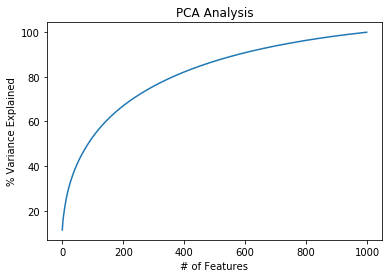

In [16]:
def plot_variance_vs_features(singular_values, cutoff):
    evr = np.array([singular_values[i]**2 / sum(singular_values**2) for i in range(cutoff)])
    var = np.cumsum(evr*100)
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(var)
    
plot_variance_vs_features(model.projection.s, max_cutoff)

The good news is this curve is very steep in the beginning, which shows that a lot of information is conveyed in the first components. However, there is no plateau that we can use to choose a cutoff!

**So, instead, we will break off a validaton set and use classifier performance to tune this hyperparameter.**

In [17]:
# random forest classifier
def rndm_forest(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 195)
    rfor = RandomForestClassifier(n_estimators=51, random_state=195)
    rfor.fit(X_train, y_train)
    return rfor.score(X_test, y_test)

In [18]:
rf_sppmi = rndm_forest(vecs_sppmi, reviews_times, y)
print(rf_sppmi)
rf_sgns = rndm_forest(vecs_sgns, reviews_times, y)
print(rf_sgns)

0.77575
0.7404


In [19]:
# logistic regression classifier
def log_reg(X, review_times, y):
    X = np.hstack((X, review_times))
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state = 195)
    logmodel = LogisticRegression(solver = 'newton-cg', multi_class = 'auto')
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    return logmodel.score(X_test, y_test)

logreg_accuracy_ssmi = log_reg(vecs_sppmi, reviews_times, y)
print(logreg_accuracy_ssmi)
logreg_accuracy_sgns = log_reg(vecs_sgns, reviews_times, y)
print(logreg_accuracy_sgns)

0.8421
0.7965666666666666


Using logistic regression on vecs_sppmi provides an accuracy around 84-86%, the best performance of our 4 models. 